<a href="https://colab.research.google.com/github/akshaya-nagarajan/MachineLearning/blob/master/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading Libraries

In [0]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Loading the CSV file from GitHub

In [675]:
url = 'https://raw.githubusercontent.com/akshaya-nagarajan/MachineLearning/master/AQ_Boston_Cam-Quincy.csv'
df = pd.read_csv(url)
df.head(5)

,['location','city','country','utc','local','parameter','value','unit','latitude','longitude','attribution'],Unnamed: 11,Unnamed: 12
0,['Portsmouth','Boston-Cambridge-Quincy','US','2020-02-09T18:00:00.000Z','2020-02-09T13:00:00-05:00','o3','0.035','ppm','43.075371','-70.748017',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""New Hampshire Dept. of Environmental ..."
1,['Odiorne State Park','Boston-Cambridge-Quincy','US','2020-02-09T18:00:00.000Z','2020-02-09T13:00:00-05:00','o3','0.038','ppm','43.045269','-70.713958',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""New Hampshire Dept. of Environmental ..."
2,['Portsmouth','Boston-Cambridge-Quincy','US','2020-02-09T18:00:00.000Z','2020-02-09T13:00:00-05:00','pm10','10','µg/m³','43.075371','-70.748017',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""New Hampshire Dept. of Environmental ..."
3,['Portsmouth','Boston-Cambridge-Quincy','US','2020-02-09T18:00:00.000Z','2020-02-09T13:00:00-05:00','pm25','4.8','µg/m³','43.075371','-70.748017',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""New Hampshire Dept. of Environmental ..."
4,['LYNN','Boston-Cambridge-Quincy','US','2020-02-09T17:00:00.000Z','2020-02-09T12:00:00-05:00','no2','0.008','ppm','42.474701','-70.971901',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""Massachusetts Dept. of Environmental ..."


### Cleaning the dataset

In [0]:
df = df.apply(lambda s:s.str.replace('\'', "").str.replace('[', ""))
df.columns = df.columns.str.strip().str.replace('[', '').str.replace(']', '').str.replace('\'','')
df.drop(df.columns[[10,11,12]], axis=1, inplace=True)

c = df['location'].astype('category')
d = dict(enumerate(c.cat.categories))
df['location'] = c.cat.codes

### Covert local column in date format

In [0]:
import datetime
df['date'] = pd.DatetimeIndex(df['local']).date
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

### Taking only one location into consideration

In [0]:
#df3 = df[(df['location'] == 7) & (df['date'] == "2020-02-09")]
df3 = df[(df['location'] == 7)]

### Pivot table to get additional columns

In [679]:
table = pd.pivot_table(df3, values='value', index=['location', 'local', 'date'], columns=['parameter'], aggfunc=np.sum, fill_value=0)
table.reset_index(inplace=True)
table.columns = table.columns.str.strip()

def covert_to_float(param):
  try:
      table[param] =  table[param].astype(float)
  except (KeyError):
      pass
    
arr = ['co','no2','o3','so2','pm10','pm25']
for i in arr:
    covert_to_float(i)
table.tail(5)

parameter,location,local,date,o3,pm10,pm25,so2
536,7,2020-02-09T09:00:00-05:00,2020-02-09,0.000,71.0,13.8,0.006
537,7,2020-02-09T10:00:00-05:00,2020-02-09,0.034,66.0,13.0,0.004
538,7,2020-02-09T11:00:00-05:00,2020-02-09,0.036,30.0,6.8,0.004
539,7,2020-02-09T12:00:00-05:00,2020-02-09,0.035,16.0,5.3,0.003
540,7,2020-02-09T13:00:00-05:00,2020-02-09,0.035,10.0,4.8,0.000


### Get 24hrs value for all the columns

In [680]:
#pd.to_datetime(table['date']).apply(lambda x: x.date())
mean_table = table.groupby(table['date']).mean()
mean_table.reset_index(inplace=True)
mean_table.head(5)

parameter,date,location,o3,pm10,pm25,so2
0,2020-01-17,7,0.032000,0.000000,4.600000,0.002000
1,2020-01-18,7,0.031208,11.416667,5.783333,0.002083
2,2020-01-19,7,0.024375,12.958333,6.500000,0.002125
3,2020-01-20,7,0.030208,14.916667,4.750000,0.001958
4,2020-01-21,7,0.028000,17.250000,6.166667,0.002417


### For calculating AQI based on 24 hrs - PM2.5 value

In [0]:
# Below code on running in anyother account will throw module aqi not found error.
# Use the below line to solve
# pip install python-aqi

In [0]:
import aqi
def calculate_pm25(value):
  aqi_2_5 = aqi.to_iaqi(aqi.POLLUTANT_PM25, str(value))
  return aqi_2_5

### For calculating AQI based on 24 hrs - PM10 value

In [0]:
def calculate_pm10(value):
  aqi_1_0 = aqi.to_iaqi(aqi.POLLUTANT_PM10, str(value))
  return aqi_1_0

### Adding columns AQI 25 and AQI 10

In [684]:
mean_table['aqi25'] = mean_table.apply(lambda x: calculate_pm25(x['pm25']), axis=1)
mean_table['aqi10'] = mean_table.apply(lambda x: calculate_pm10(x['pm10']), axis=1)
mean_table.drop(['date'], axis=1,inplace=True)
alt_mean_table = mean_table
alt_mean_table.head()

parameter,location,o3,pm10,pm25,so2,aqi25,aqi10
0,7,0.032000,0.000000,4.600000,0.002000,19,0
1,7,0.031208,11.416667,5.783333,0.002083,24,10
2,7,0.024375,12.958333,6.500000,0.002125,27,11
3,7,0.030208,14.916667,4.750000,0.001958,20,13
4,7,0.028000,17.250000,6.166667,0.002417,25,16


### Silhouette score

In [685]:
from sklearn.metrics import silhouette_score
#Use silhouette score
range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(alt_mean_table)
    centers = clusterer.cluster_centers_
    score = silhouette_score(alt_mean_table, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5434121623142208)
For n_clusters = 3, silhouette score is 0.4605772798435616)
For n_clusters = 4, silhouette score is 0.41054462813573744)
For n_clusters = 5, silhouette score is 0.3656004715846426)
For n_clusters = 6, silhouette score is 0.43775036592217503)
For n_clusters = 7, silhouette score is 0.45636719904719486)
For n_clusters = 8, silhouette score is 0.4082242258038827)
For n_clusters = 9, silhouette score is 0.4209505270704577)


### Elbow method

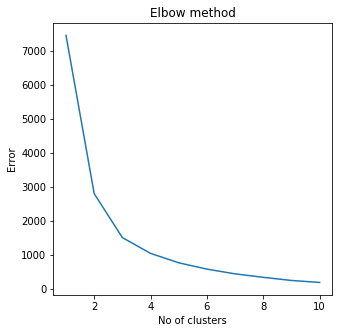

In [686]:
def elbow_method():
    Error =[]
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i).fit(alt_mean_table)
        kmeans.fit(alt_mean_table)
        Error.append(kmeans.inertia_)
    plt.figure(figsize=(5,5))
    plt.plot(range(1, 11), Error)
    plt.title('Elbow method')
    plt.xlabel('No of clusters')
    plt.ylabel('Error')
    plt.show()
    
elbow_method()

### Applying KMeans clustering - 3 clusters

In [687]:
kmeans = KMeans(n_clusters=3)
#y = kmeans.fit_predict(alt_mean_table[['aqi25', 'pm25','pm10','aqi10','o3']])
y = kmeans.fit_predict(alt_mean_table.iloc[:,1:].values)
alt_mean_table['cluster'] = y
alt_mean_table.tail()

parameter,location,o3,pm10,pm25,so2,aqi25,aqi10,cluster
19,7,0.027667,19.250000,5.920833,0.002250,25,18,2
20,7,0.027208,7.333333,4.220833,0.001958,18,6,1
21,7,0.025958,2.708333,1.737500,0.001917,7,2,1
22,7,0.034000,9.375000,3.575000,0.002000,15,8,1
23,7,0.026429,22.571429,6.871429,0.002429,28,20,2


### Plotting AQI index and O3 values

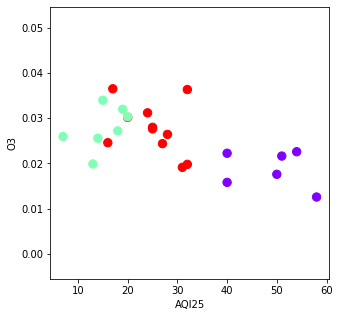

In [688]:
plt.figure(figsize=(5,5))
plt.scatter(alt_mean_table['aqi25'], alt_mean_table['o3'], s=70, c=y, cmap='rainbow')
plt.xlabel('AQI25')
plt.ylabel('O3')
plt.show()

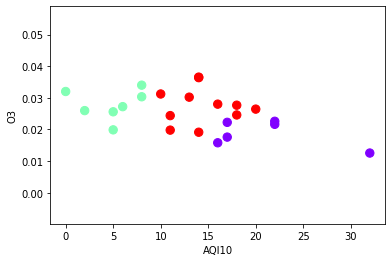

In [689]:
plt.scatter(alt_mean_table['aqi10'], alt_mean_table['o3'], s=70, c=y, cmap='rainbow')
plt.xlabel('AQI10')
plt.ylabel('O3')
plt.show()

### GMM Clustering - 3 clusters

In [690]:
from sklearn.mixture import GaussianMixture
alt_mean_table.drop(['cluster'], axis=1,inplace=True)
gmm = GaussianMixture(n_components = 3 , covariance_type='spherical').fit(alt_mean_table.iloc[:,1:].values)
y_gmm = gmm.predict(alt_mean_table.iloc[:,1:].values)
alt_mean_table['clusterGMM'] = y_gmm
alt_mean_table.tail()

parameter,location,o3,pm10,pm25,so2,aqi25,aqi10,clusterGMM
19,7,0.027667,19.250000,5.920833,0.002250,25,18,0
20,7,0.027208,7.333333,4.220833,0.001958,18,6,1
21,7,0.025958,2.708333,1.737500,0.001917,7,2,1
22,7,0.034000,9.375000,3.575000,0.002000,15,8,1
23,7,0.026429,22.571429,6.871429,0.002429,28,20,0


### Plotting AQI index and O3 values

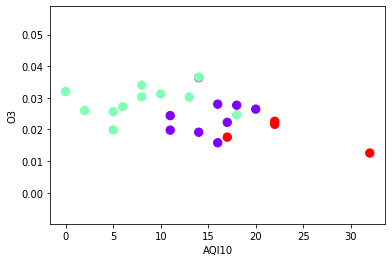

In [691]:
plt.scatter(alt_mean_table['aqi10'], alt_mean_table['o3'], s=70, c=y_gmm, cmap='rainbow');
plt.xlabel('AQI10')
plt.ylabel('O3')
plt.show()

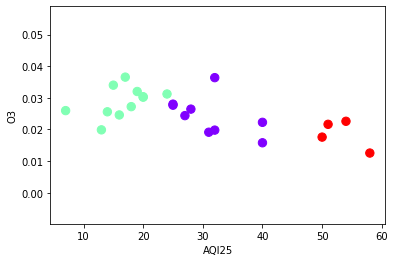

In [692]:
plt.scatter(alt_mean_table['aqi25'], alt_mean_table['o3'], s=70,c=y_gmm, cmap='rainbow');
plt.xlabel('AQI25')
plt.ylabel('O3')
plt.show()